# Facial expresson models

#### Using FER2013 database (greyscale image and CSV file) and Convolutional Neural Network (CNN).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# Check if GPU is available
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Model 1: Trained on FER2013 image dataset using VGG16

### Load data

In [3]:
# Load data from training and test directories
# Dataset reference: https://www.kaggle.com/datasets/msambare/fer2013
train_dir = 'FER-2013/train'
test_dir = 'FER-2013/test' 

### Data preprocessing and augmentation

In [4]:
# Data augmentation for training and Validation Split
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2  # 20% data for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Training image directory
    target_size=(48, 48), # Resize 
    batch_size=32,  # Batch size 
    class_mode='categorical',  # Categorical crossentropy
    subset='training' # Label as training data
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir, # Training image directory
    target_size=(48, 48), # Resize 
    batch_size=32, # Batch size (larger batch)
    class_mode='categorical',  # Categorical crossentropy
    subset='validation'  # Label as validation data
)

# Test data preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir, # Test image directory
    target_size=(48, 48), # Resize 
    batch_size=64, # Batch size (larger batch: Faster testing)
    class_mode='categorical' # Categorical crossentropy
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Build the model

In [5]:
# Load VGG16 model without top layers - pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))  

# Freeze the first 8 layers
for i, layer in enumerate(base_model.layers):
    if i < 8:
        layer.trainable = False  # First 8 layers
    else:
        layer.trainable = True   # Unfreeze remaining layers

# Build custom CNN model
model = models.Sequential()  # Initialize Sequential model
model.add(base_model)  # Add pre-trained VGG16 model
model.add(layers.Flatten()) # Flatten
# Add layers
'''
# Initial layers: More shallow network 
model.add(Dense(1024, activation='relu'))   # First layer
model.add(Dropout(0.5)) # Dropout layer (50%)
model.add(Dense(512, activation='relu')) # Second layer
model.add(Dropout(0.4))  #  # Dropout layer (40%)
model.add(Dense(256, activation='relu')) # Third layer
model.add(Dropout(0.3)) # Dropout layer (30%)
'''
# Fine-tuned layers: Deeper network
model.add(Dense(2048, activation='relu'))  # First layer
model.add(Dropout(0.5))  # Dropout layer (50%)
model.add(Dense(1024, activation='relu'))  # Second layer
model.add(Dropout(0.4))  # Dropout layer (40%)
model.add(Dense(512, activation='relu'))  # Third layer
model.add(Dropout(0.3))  # Dropout layer (30%)
model.add(Dense(256, activation='relu'))  # Fourth layer
model.add(Dropout(0.2))  # Dropout layer (20%)
model.add(Dense(128, activation='relu'))  # Final layer
model.add(Dropout(0.2))  # Dropout layer (20%)
model.add(Dense(7, activation='softmax'))  # Softmax output layer

# Compile model using Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [6]:
# Callbacks
# Early stop
early_stop = EarlyStopping(
    monitor='val_accuracy', # Dependent
    patience=10, # Wait for 5 epochs
    verbose=0,  # Output details
    mode="max",  # Mode
    restore_best_weights=True
)
# Learning rate reduction 
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', # Dependent
    factor=0.2,  # Reduction factor
    patience=5,  # Wait for 5 epochs
    verbose=0,   # Output details
    mode='min',  # Mode
    min_lr=1e-6  # Minimum learning rate
)

# Save best model observed
model_checkpoint = ModelCheckpoint(
    'expression_model_VGG16.h5', # Model export filename
    monitor="val_accuracy", # Dependent
    verbose=1,  # Output details
    mode="max", # Mode
    save_best_only=True # Save when best model is observed
)

# Train model
history = model.fit(
    train_generator,  # Training data
    validation_data=validation_generator,   # Validation data
    epochs=60,  # Epochs
    callbacks=[early_stop, lr_reduction, model_checkpoint]  # Callbacks
)


Epoch 1/60
717/718 [============================>.] - ETA: 0s - loss: 1.7507 - accuracy: 0.2721
Epoch 1: val_accuracy improved from -inf to 0.34018, saving model to expression_model_VGG16.h5
718/718 [==============================] - 27s 34ms/step - loss: 1.7507 - accuracy: 0.2722 - val_loss: 1.5832 - val_accuracy: 0.3402 - lr: 1.0000e-04
Epoch 2/60
718/718 [==============================] - ETA: 0s - loss: 1.5605 - accuracy: 0.3622
Epoch 2: val_accuracy improved from 0.34018 to 0.42083, saving model to expression_model_VGG16.h5
718/718 [==============================] - 24s 33ms/step - loss: 1.5605 - accuracy: 0.3622 - val_loss: 1.4810 - val_accuracy: 0.4208 - lr: 1.0000e-04
Epoch 3/60
718/718 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.4254
Epoch 3: val_accuracy improved from 0.42083 to 0.45689, saving model to expression_model_VGG16.h5
718/718 [==============================] - 24s 33ms/step - loss: 1.4301 - accuracy: 0.4254 - val_loss: 1.3690 - val_accur

### Evaluate the model

#### Calculate metrics

In [7]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Retrieve predicted classes
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Retrieve true labels
y_true = test_generator.classes 

# Calculate metrics
precision = precision_score(y_true, y_pred_classes, average='weighted') # Precision
recall = recall_score(y_true, y_pred_classes, average='weighted') # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted') # F1 score

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

113/113 [==============================] - 3s 27ms/step
Test Accuracy: 0.6552
Test Loss: 1.0801
Precision: 0.1836
Recall: 0.1832
F1 Score: 0.1832


#### Accuracy and loss plots

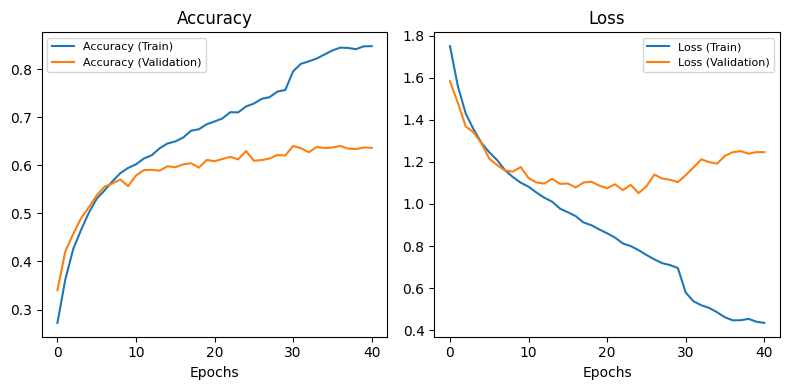

In [8]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

plt.tight_layout()
plt.show()


#### Confusion matrix

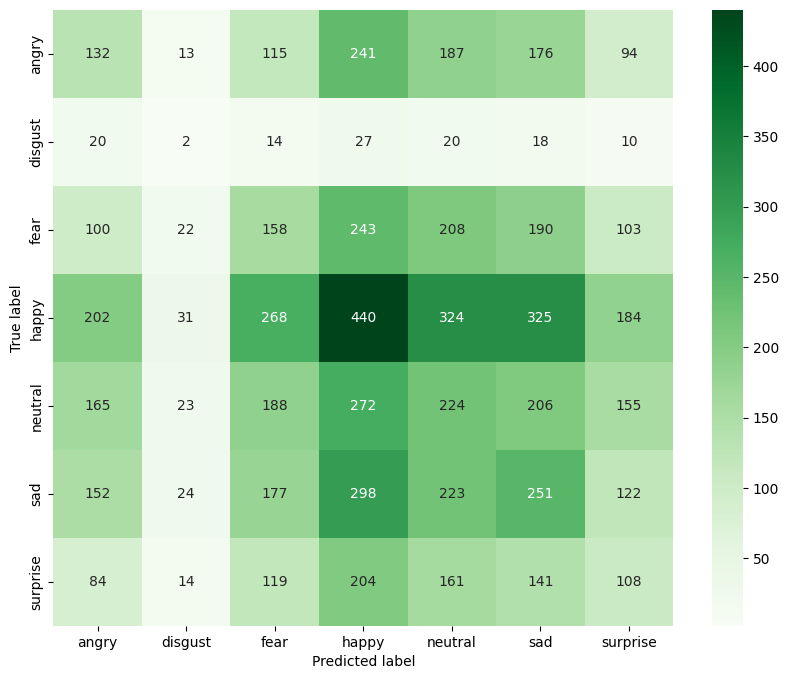

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Classification report

In [10]:
# Classification report
c_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(c_report)

              precision    recall  f1-score   support

       angry       0.15      0.14      0.15       958
     disgust       0.02      0.02      0.02       111
        fear       0.15      0.15      0.15      1024
       happy       0.26      0.25      0.25      1774
     neutral       0.17      0.18      0.17      1233
         sad       0.19      0.20      0.20      1247
    surprise       0.14      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



### Conclusion

## Model 2: Trained on FER2013 CSV dataset using a custom CNN

### Load data

In [11]:
# Import FER-2013 dataset in CSV format
# Reference: https://www.kaggle.com/datasets/deadskull7/fer2013
df  = pd.read_csv('fer2013.csv')

# Print data snippet
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


### Data preprocessing 

In [12]:
# Initialize training, validation, and test arrays
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# DataFrames for each array
train_df = df[df['Usage'] == 'Training']
test_df = df[df['Usage'] == 'PrivateTest']
val_df = df[df['Usage'] == 'PublicTest']

# Convert image data to numpy arrays
# Training array
X_train = np.array(train_df['pixels'].str.split(" ").tolist(), dtype='float').reshape(-1, 48, 48, 1) # Convert pixels 
y_train = to_categorical(np.array(train_df['emotion']), num_classes=7) # Convert to categorial and extract emotions 

# Testing array
X_test = np.array(test_df['pixels'].str.split(" ").tolist(), dtype='float').reshape(-1, 48, 48, 1) # Convert pixels 
y_test = to_categorical(np.array(test_df['emotion']), num_classes=7) # Convert to categorial and extract emotions 

# Validation array
X_val = np.array(val_df['pixels'].str.split(" ").tolist(), dtype='float').reshape(-1, 48, 48, 1) # Convert pixels (reshape ensures correct shape of images)
y_val = to_categorical(np.array(val_df['emotion']), num_classes=7) # Convert to categorial and extract emotions 

# Print shapes of training, validation, and test arrays
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape



((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

### Build the model

In [13]:
#fine tuned model
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

# Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

# Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Add a pooling layer here to maintain dimensions
model.add(layers.MaxPool2D((2, 2)))

# Block 4
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

# Block 5
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

# Compile the model using stochastic gradient descent optimizer and categorical crossentropy loss
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [14]:
# Callbacks
# Early stop
early_stop = EarlyStopping(
    monitor='val_accuracy', # Dependent
    patience=10, # Wait for 5 epochs
    verbose=0,  # Output details
    mode="max",  # Mode
    restore_best_weights=True
)
# Learning rate reduction 
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', # Dependent
    factor=0.2,  # Reduction factor
    patience=5,  # Wait for 5 epochs
    verbose=0,   # Output details
    mode='min',  # Mode
    min_lr=1e-6  # Minimum learning rate
)

# Save best model observed
model_checkpoint = ModelCheckpoint(
    'expression_model_CSV.h5', # Model export filename
    monitor="val_accuracy", # Dependent
    verbose=1,  # Output details
    mode="max", # Mode
    save_best_only=True # Save when best model is observed
)

# Train model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    callbacks=[early_stop, lr_reduction, model_checkpoint],  # Callbacks
    validation_data=(X_val,y_val) # Validation data
)


Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.8186 - accuracy: 0.2891
Epoch 1: val_accuracy improved from -inf to 0.37726, saving model to expression_model_CSV.h5
898/898 [==============================] - 15s 16ms/step - loss: 1.8186 - accuracy: 0.2891 - val_loss: 1.5777 - val_accuracy: 0.3773 - lr: 0.0100
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 1.5103 - accuracy: 0.4122
Epoch 2: val_accuracy did not improve from 0.37726
898/898 [==============================] - 13s 15ms/step - loss: 1.5103 - accuracy: 0.4122 - val_loss: 1.6919 - val_accuracy: 0.3424 - lr: 0.0100
Epoch 3/50
896/898 [============================>.] - ETA: 0s - loss: 1.3538 - accuracy: 0.4789
Epoch 3: val_accuracy improved from 0.37726 to 0.42184, saving model to expression_model_CSV.h5
898/898 [==============================] - 14s 15ms/step - loss: 1.3537 - accuracy: 0.4789 - val_loss: 1.5023 - val_accuracy: 0.4218 - lr: 0.0100
Epoch 4/50
896/898 [==============

### Evaluate the model

#### Calculate metrics

In [15]:
# Predict and determine classes
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Initialize and update metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
iou = tf.keras.metrics.MeanIoU(num_classes=7)

for metric in [precision, recall, iou]:
    metric.update_state(y_true, y_pred)

# Calculate F1 score from precision and recall
precision_value, recall_value = precision.result().numpy(), recall.result().numpy()
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())

# Print results
print(f"Precision: {precision_value:.4f}")
print(f"Recall: {recall_value:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"IoU: {iou.result().numpy():.4f}")

113/113 [==============================] - 1s 3ms/step
Precision: 0.9265
Recall: 0.9199
F1 Score: 0.9232
IoU: 0.4219


### Plot accuracy and loss

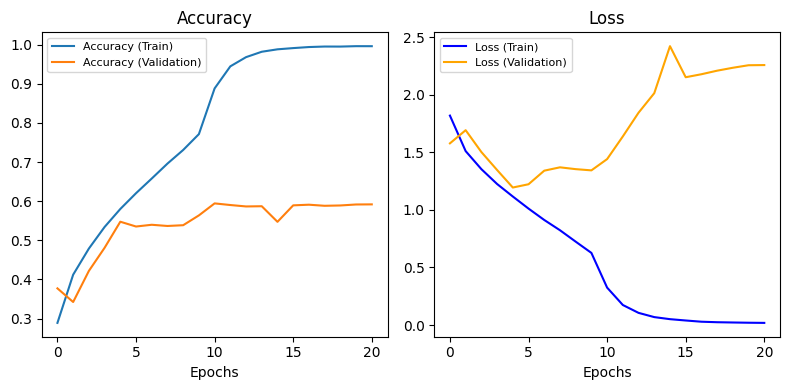

In [16]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

# Loss plot
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (Validation)', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

plt.tight_layout()
plt.show()


#### Confusion matrix

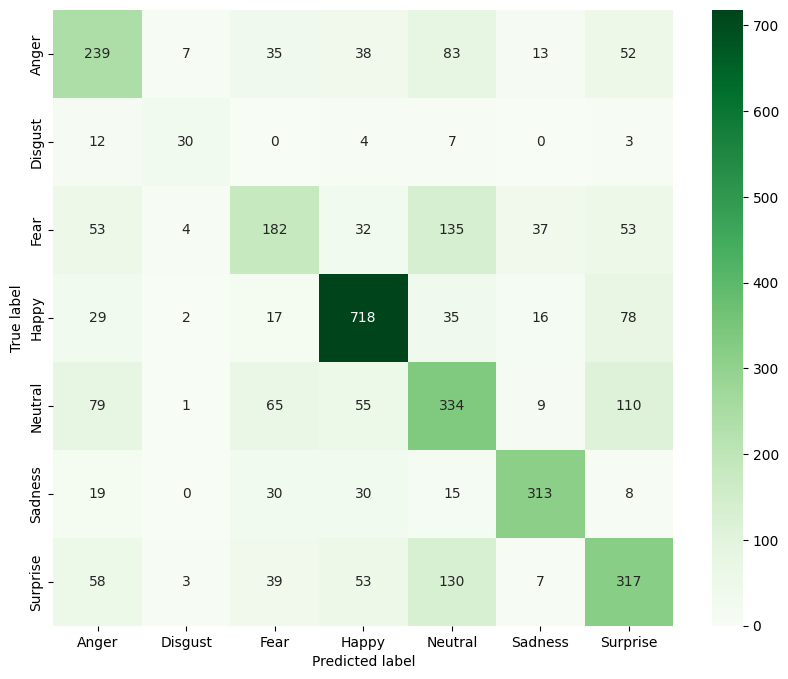

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Emotion labels
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, 
            yticklabels=labels) 
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#### Classification report

In [20]:
# Classification report
c_report_csv = classification_report(y_true, y_pred, target_names=labels)
print(c_report_csv)

              precision    recall  f1-score   support

       Anger       0.49      0.51      0.50       467
     Disgust       0.64      0.54      0.58        56
        Fear       0.49      0.37      0.42       496
       Happy       0.77      0.80      0.79       895
     Neutral       0.45      0.51      0.48       653
     Sadness       0.79      0.75      0.77       415
    Surprise       0.51      0.52      0.52       607

    accuracy                           0.59      3589
   macro avg       0.59      0.57      0.58      3589
weighted avg       0.59      0.59      0.59      3589



### Conclusion